<div style="width:image width px; font-size:75%; text-align:left;">
    <img src="visuals/rename.jpg" width="1000" height="height" style="padding-bottom:0.2em;" />
    <figcaption>Photo by Kevin Ku on Unsplash.com</figcaption>
</div>

# Projektarbeit - Analyse von Förderungstätigkeiten des Auswärtigen Amtes
- Student: Daniel Müller
- Matrikelnummer: *******
- Vorlesung: Angewandte Programmierung
- Dozent: D****** G*****+

# Gliederung

* Definition der Fragestellung [[1]](#1)
* Packages einlesen [[2]](#2)
* Datei einlesen und in Dataframe konvertieren [[3]](#3)
* Übersicht Datenstrukturen [[4]](#4)
* Erste Visualisierungen [[5]](#5)
    * Partizipierende Organisationen [[6]](#6)
    * Budget Vs Kosten [[7]](#7)
    * Die Größten Geldempfänger und die Verteilung [[8]](#8)
* Text Mining Ansatz zur Clusterung [[9]](#9)
    * Preprocessing [[10]](#10)
    * Clusteranzahl definieren [[11]](#11)
    * Training ML [[12]](#12)
* Visualisierung der ML Ergebnisse [[13]](#13)
    * Dimensionsreduktion [[14]](#14)
    * Scatterplot [[15]](#15)
* Fazit / Ausblick  [[16]](#16)
* Quellenverzeichnis [[17]](#quellenverzeichnis)

## Definition der Fragestellung:  <a class="anchor" id="1"></a> 

ZUr Untersuchung des Datensatzes sind sich die folgenden Fragen gestellt worden. Diese sollen mithilfe der Daten beantwortet werden:

1. Mit welchen Organisationen hat das Auswärtige Amt hauptsächlich zusammengearbeitet?
2. Wie viel Budget und Kosten sind in den Jahren dokumentiert? 
3. Gibt es Jahre in denen die Ausgaben das Budget überstiegen haben?
4. Welche Organisationen haben besonders viel Geld vom Auswärten Amt erhalten?
5. Ist es möglich Themen Felder mithilfe von Machine Learning zu identifizieren?

## Einlesen der Packages & Module <a class="anchor" id="2"></a> 

Siehe Quellenverzeichnis für die Dokumentation der verwendeten Packages - [[Zum Quellenverzeichnis]](#quellenverzeichnis)

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from modules import functions as fu
from modules import textprocessing as tp
import spacy
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.options.display.float_format = '{:,.2f}'.format

### Aktueller Pfad und Dateiinformationen 
- Datenquelle: https://www.auswaertiges-amt.de/blob/2107758/446327c4229e03967bb7818abe399eba/iati-weltweit-data.xml
- Lizenz: Creative Commons Namensnennung – 4.0 International (CC BY 4.0)
- Weitere Informationen: https://www.govdata.de/web/guest/suchen/-/details/manahmen-in-asien

In [3]:
ordner = fu.get_current_path()
xml_data = open(ordner + '/data/database.xml', 'r', encoding="mbcs").read() 

## Daten einlesen und in ein Dataframe konvertieren <a class="anchor" id="3"></a> 
Dazu wurde ein Package zum lesen von XML Daten verwendet über dieser wurde iteriert und die wichtigen Punkte wurden in dem DataFrame hinzugefügt.

In [4]:
root = ET.fromstring(xml_data)

columns = ["ID","last_update", "reporting_org_en", "reporting_org_de", "title","title_de"
           , "description", "description_de","participating_org", "status","planned_projectstart","planned_projectend"
           ,"sector","budget","costs", "dic_budg", "dic_costs"]

df = pd.DataFrame(columns = columns)
budgetall = []
costall = []
for node in root: 
    part_org = {}
    budget = {}
    budgetsum = 0
    costs = {}
    costsum = 0
    update = node.attrib["last-updated-datetime"]
    ident = np.nan
    reporg1 = np.nan
    reporg2 = np.nan
    title_en = np.nan
    title_de = np.nan
    desc_en = np.nan
    desc_de = np.nan
    status = np.nan
    plan_start = np.nan
    plan_end = np.nan
    sect = np.nan
    for n in node:
        
        if n.tag == "iati-identifier":
            ident = n.text
        elif n.tag == "reporting-org":
            reporg1 = n[0].text
            reporg2 = n[1].text
        elif n.tag == "participating-org":
            nkeys = len(part_org) + 1
            part_org[nkeys] = n[0].text
        elif n.tag == "title":
            title_en = n[0].text
            title_de = n[1].text
            #print(title_de)
        elif n.tag == "description":
            desc_en =  n[0].text
            desc_de =  n[1].text
        elif n.tag == "activity-status":
            status = n.attrib
        elif n.tag == "activity-date":
            if n[0].text == "geplanter Projektbeginn":
                plan_start = n.attrib["iso-date"]
            if n[0].text == "geplantes Projektende":
                plan_end = n.attrib["iso-date"]
        elif n.tag == "sector":
            if "code" in n.attrib.keys():
                sect = n.attrib["code"]
            else:
                sect = n[0].text
        elif n.tag == "budget":
            budgetsum += float(n[2].text)
            numb = len(budget) + 1
            budget[numb] = {"begin":n[0].attrib["iso-date"], "end":n[1].attrib["iso-date"], "value": n[2].text}
            budgetall.append([ident,budget[numb]["begin"], budget[numb]["value"] ])
        elif n.tag == "transaction":
            costsum += float(n[2].text) 
            numb = len(costs) + 1
            costs[numb] = {"date":n[1].attrib["iso-date"], "value": n[2].text, "receiver": n[3][0].text}
            costall.append([ident,costs[numb]["date"], costs[numb]["value"], costs[numb]["receiver"] ])
    
    df = df.append(pd.Series([ident, update, reporg1, reporg2, title_en, title_de,
                              desc_en,desc_de, part_org, status, plan_start, plan_end,sect,budgetsum, costsum,budget, costs], index = columns), ignore_index = True)

## Übersicht der Datenstrukturen <a class="anchor" id="4"></a> 
- Anzahl der Zeilen und Spalten
- Anzahl der Datensätze mit Null
- Erster Einblick in die Daten.

In [5]:
print("Number of Rows, Columns: ", df.shape)
seriesObj = df.apply(lambda x: x.isnull().any(), axis=1)
print("Number of Rows with Null Values: ", len(seriesObj[seriesObj == True].index))

Number of Rows, Columns:  (701, 17)
Number of Rows with Null Values:  0


In [6]:
df.head()

,ID,last_update,reporting_org_en,reporting_org_de,title,title_de,description,description_de,participating_org,status,planned_projectstart,planned_projectend,sector,budget,costs,dic_budg,dic_costs
0,XM-DAC-5-7-6600123,2019-07-02T09:13:54,Germany - Federal Foreign Office,Deutschland - AuswÃ¤rtiges Amt,DAAD - Transitional Partnerships,DAAD - Transformationspartnerschaften,Assisting in the construction of sustainable s...,UnterstÃ¼tzung beim Aufbau nachhaltiger Hochsc...,{1: 'Deutscher Akademischer Austauschdienst e....,{'code': '4'},2017-10-15,2018-12-31,11420,"5,362.00",0,"{1: {'begin': '2017-10-15', 'end': '2017-12-31...",{}
1,XM-DAC-5-7-6605710,2020-04-20T13:18:06,Germany - Federal Foreign Office,Deutschland - AuswÃ¤rtiges Amt,Occupational training,Berufsbegleitende LehrgÃ¤nge,Capacity Building in the diplomatic service. I...,"KapazitÃ¤tsaufbau im diplomatischen Dienst, Le...","{1: 'Eigene MaÃŸnahme Ressort/Bundesland', 2: ...",{'code': '4'},2017-01-09,2019-12-31,15110,"426,386.55","622,117.59","{1: {'begin': '2017-01-09', 'end': '2017-12-31...","{1: {'date': '2017-12-15', 'value': '35870.32'..."
2,XM-DAC-5-7-6605715,2020-05-28T11:41:57,Germany - Federal Foreign Office,Deutschland - AuswÃ¤rtiges Amt,Development/consolidation alumni network,Pflege/Ausbau des Alumni-Netzwerkes,capacity building in the diplomatic service. D...,KapazitÃ¤tsaufbau im diplomatischen Dienst\nVe...,"{1: 'Eigene MaÃŸnahme Ressort/Bundesland', 2: ...",{'code': '4'},2017-01-09,2019-12-15,15110,"1,683,682.11","2,883,095.94","{1: {'begin': '2017-01-09', 'end': '2017-12-31...","{1: {'date': '2017-12-15', 'value': '165158.76..."
3,XM-DAC-5-7-6606786,2019-07-02T09:13:55,Germany - Federal Foreign Office,Deutschland - AuswÃ¤rtiges Amt,GER Assessed Contribution to UN regular budget,Deutscher Pflichtbeitrag an die VN - RegulÃ¤re...,Assessed Contribution by Member States to the ...,Pflichtbeitrag zum regulÃ¤ren VN-Haushalt,"{1: 'United Nations Agency, Fund or Commission...",{'code': '4'},2018-01-01,2018-12-31,43010,"29,429,820.00","44,754,429.97","{1: {'begin': '2018-01-01', 'end': '2018-12-31...","{1: {'date': '2018-01-15', 'value': '22769059...."
4,XM-DAC-5-7-6607894,2019-07-02T09:16:54,Germany - Federal Foreign Office,Deutschland - AuswÃ¤rtiges Amt,Scholarships for foreign students,Stipendien fÃ¼r auslÃ¤ndische Studierende,"Development of educated classes in society, pr...","Aufbau von Bildungsschichten im Ausland, FÃ¶rd...","{1: 'Konrad-Adenauer-Stiftung (KAS)', 2: 'Germ...",{'code': '4'},2015-01-01,2018-12-31,11420,"2,682,550.00","248,950.00","{1: {'begin': '2015-01-01', 'end': '2015-12-31...","{1: {'date': '2018-01-15', 'value': '124475', ..."


## Erste Visualisierungen erstellen und beantworten der ersten Fragen <a class="anchor" id="5"></a> 
- Wie viele Unterschiedliche Organisationen haben partizipiert?
- Wie viel Budget für die Projekte gab es in den letzten Jahren?
- Wie viele Kosten haben die Projekte in den Jahren verursacht?
- Wer empfängt wieviel Geld?
- Wie verteilt sich die Höhe der verschiedenen Zahlungen?

## Wie viele unterschiedliche Organisationen partizipieren? <a class="anchor" id="6"></a> 
- Insgesamt haben wir 352 unterschiedliche Organisationen die in dem Datensatz mit dem Auswärtigen Amt zusammengearbeitet haben.
- Zu den Top Organisationen gehöhr die Organisation für Sicherheit und Zusammenarbeit in Europe, sowie die Deutsche Welle.
- Ein weiterer großer Partner sind die Bundesländer. Allerdings lassen sich diese nicht weiter unterscheiden.

In [7]:
import matplotlib.pyplot as plt

Anzahl unterschiedliche beteiligte Organisationen:  zahl    352
dtype: int64


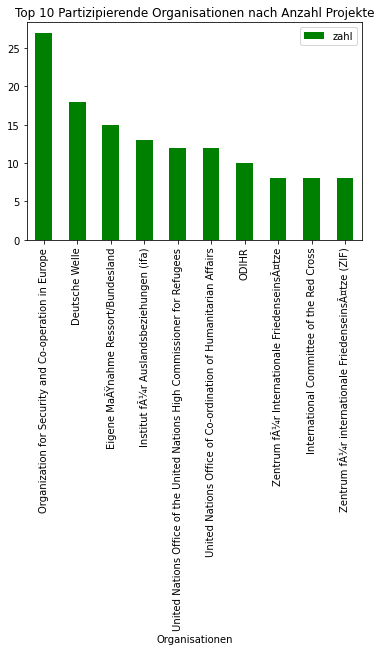

In [8]:
partlist = []

df["participating_org"].apply(lambda x: partlist.append(fu.dic_iterieren(x)) )
partlist = pd.DataFrame(partlist, columns = ["Organisationen"])
partlist["zahl"] = 1
partygroup = partlist.groupby(["Organisationen"]).count().sort_values(["zahl"], ascending=False)
partygroup[:10].plot.bar(color = "green", title = "Top 10 Partizipierende Organisationen nach Anzahl Projekte")
print("Anzahl unterschiedliche beteiligte Organisationen: ", partygroup.count())

## Kosten und Budget Vergleich <a class="anchor" id="7"></a> 
- Die im Datensatz enthaltenen Projekte haben vor allem im Jahr 2019 + 2020 Kosten verursacht.
- Auffällig ist, dass Kosten bereits in der Zukunft eingetragen sind.
- Im Allgemeinen bleiben die Kosten in den einzelnen Jahren unter den jeweiigen Budgets.

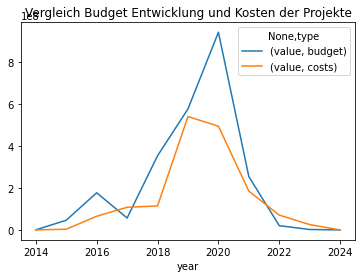

In [9]:
budgetall = pd.DataFrame(budgetall, columns=["id","date","value"])
budgetall["date"] = pd.to_datetime(budgetall["date"])
budgetall["year"] = budgetall["date"].dt.year
budgetall["value"] = budgetall["value"].astype(float)
yearbudget = budgetall[["year","value"]].groupby(["year"]).sum()
yearbudget["type"] = "budget"

costall = pd.DataFrame(costall, columns=["id","date","value", "receiver"])
costall["date"] = pd.to_datetime(budgetall["date"])
costall["year"] = costall["date"].dt.year
costall["value"] = costall["value"].astype(float)
yearcost = costall[["year","value"]].groupby(["year"]).sum()
yearcost["type"] = "costs"
costmerged = yearcost.append(yearbudget).reset_index()
costmerged = costmerged.pivot(index="year", columns="type", values=["value"])
costmerged.plot(title= "Vergleich Budget Entwicklung und Kosten der Projekte")

## Analyse der größten Geldempfänger <a class="anchor" id="8"></a> 
- Die größten Geldsummen sind an das UNHCR gegangen. ( UN Organisation für Koordinierung von Flüchtlingshilfen)
- In den Top 10 Organisationen sind fast nur Hilfsorganisationen oder Programme aufgeführt. 

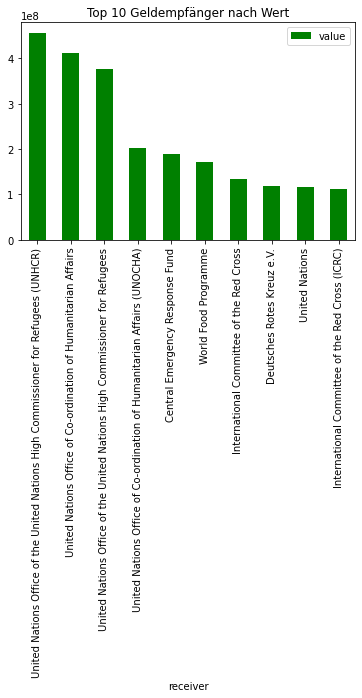

In [10]:
costreceiver = costall[["receiver","value"]]
creceivergroup = costreceiver.groupby(["receiver"]).sum().sort_values(["value"], ascending=False)
creceivergroup[:10].plot.bar(color = "green", title = "Top 10 Geldempfänger nach Wert")

## Fortsetzung Analyse Geldempfänger
- Fast 50% der Werte der Transaktionen sind an die 5 größten Geldempfänger gegangen.

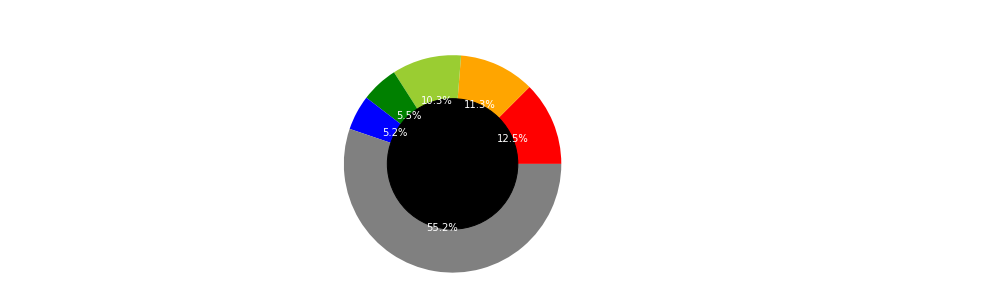

In [11]:
piereceiver = creceivergroup[:5].reset_index()
sumtest = pd.DataFrame([["Other",0]], columns = ["receiver","value"])
sumtest["value"] = sum(creceivergroup["value"][6:])
piereceiver = piereceiver.append(sumtest).reset_index()

plt.figure(figsize=(5, 5))
colorlist = ["red","orange","yellowgreen","green","blue","grey"]
plt.pie(piereceiver["value"], labels=piereceiver["receiver"], autopct='%1.1f%%', colors= colorlist, textprops={"color":"white"})
central_circle = plt.Circle((0, 0), 0.6, color='black')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Top 5 Empfänger Organisationen ", fontsize=20, color = "white")
plt.show()

## Text Mining Ansatz um ähnliche Projekte zu Clustern <a class="anchor" id="9"></a> 
- text daten in ein Feld zusammenführen ( title + description)
- Preprocessing Pipeline mit Spacy und SKLEARN bauen (submodule für funktionen)
- Wörter in Vectoren umwandeln mit TF-IDF Vectorizer
- Identifikation von potenziellen Clustern mit Elbow Methode + Silhoutte Coefficient
- Training & Evaluierung des K-Means Modells
- Prüfung der zentralen Wörter je Cluster und ggf. Titel definieren
- Visualisierung der Cluster <a class="anchor" id="10"></a> 

In [12]:
text = df["title"] + ' ' + df["description"]

nlp = spacy.load('en_core_web_md')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

spacy_estimators = [('tokenizer', tp.pipelinize(tp.normalizer)), ('preprocessor', tp.pipelinize(tp.preprocessor))]
spacy_pipe = Pipeline(spacy_estimators)
output = spacy_pipe.transform(text)
newlist = []

## Prüfung ob die Rückmeldung ein String ist oder eine Liste 
- Habe ich mir angewöhnt noch einmal zu machen, da es in der Vergangenheit zu Problemen geführt hatte bei der Interpretation. So ist sichergestellt, dass das Programm mit allen Daten umgehen kann.

In [13]:
if not isinstance(output,str):
    for row in output:
        if isinstance(row, tuple) or isinstance(row,list):
            row = " ".join(row)
        newlist.append(row)
else:
    newlist.append(output)

## Umwandlung der Wörter bzw. Datensätze in einen Vector
- Ich verwende dazu den TfIDF Vectorizer. Alternativ geht auch das Word2Vec Modul.
- Der TF IDF nutzt ein einfaches Prinzip. Es wird angenommen, je Häufiger ein Wort in einem Satz vorkommt und je seltener im gesamten Dokument. Desto wichtiger ist es für die Bedeutung des satzes.
- Term Frequency * Inverse Document Frequency (TFIDF)
- Trotz der recht einfachen Logik können mit dem TFIDF Vectorizer bereits sehr gute Ergebnisse erzielt werden.
- Word2Vec dagegen arbeitet im Hintergrund mit einem trainierten Neuronalen Netz, dass die N-Grams für jedes Wort bildet und so Kontext bezogene Vektoren für jedes Wort erzeugt.

In [14]:
df["processed_txt"] = newlist
vectorizer = TfidfVectorizer(max_features=1100, max_df = 0.4, min_df = 1)
X = vectorizer.fit_transform(newlist)
X.shape

(701, 1100)

## Herausfinden der optimalen Anzahl an Cluster für den K-Means Algorithmus <a class="anchor" id="11"></a> 
### Anwendung Elbow Methode
K-Means muss die Anzahl der erwarteten Cluster vorgegeben bekommen.
Um abzuschätzen welche Clusteranzahl passend ist, wird der Single Square Error berechnet. Wenn man dies automatisch mit verschiedenen clustern berechnen lässt,
dann kann man grafisch sich den Verlauf des SSE anzeigen lassen. Im Idealfall macht der Graph dann an einer Stelle einen Knick und dieser Punkt markiert dann die Anzahl an Cluster die eine möglichst gute Cluster einsortierung ermöglicht.
Wenn die Methode nicht ausreicht kann zusätzlich noch der Silhouette Co Efficient zur Evaluierung berechnet werden.

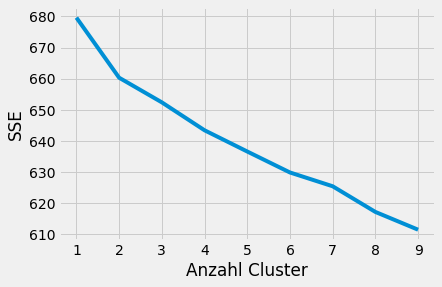

In [15]:
# Stelle die Parameter für den KMeans ein
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
     }
srange = 10
# Berechne für 15 verschiedene Cluster den Single Square Error
# Es gilt -> je kleiner desto besser
sse = []
for k in range(1, srange):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

#plt.rc("xtick",color = "black")
#plt.rc("ytick",color = "black")
#plt.rc("text", color = "black")
# plot die Ergebnisse
plt.style.use("fivethirtyeight")
plt.plot(range(1, srange), sse)
plt.xticks(range(1, srange))
plt.xlabel("Anzahl Cluster")
plt.ylabel("SSE")
plt.show()

## Silhouette Co Efficient berechnen
der Co Efficient ist ein weiteres Maß um die Zuordnung der einzelnen Datenpunkte zu einem Cluster zu bewerten. Je höher der Silhouette Co Efficient, desto besser lassen sich die Datenpunkte einem Cluster zuordnen.

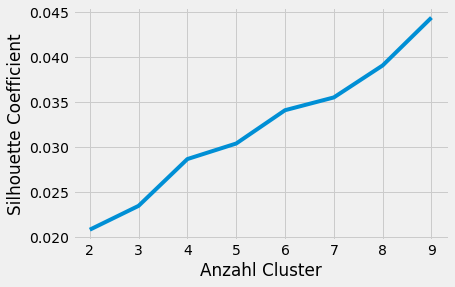

In [16]:
# Berechne den silhouette coefficient -> es gilt je höher desto besser
silhouette_coefficients = []
for k in range(2, srange):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

#plot die Ergebnisse
plt.style.use("fivethirtyeight")
plt.plot(range(2, srange), silhouette_coefficients)
plt.xticks(range(2, srange))
plt.xlabel("Anzahl Cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

## Training des modells mit der optimalen Anzahl an Custern <a class="anchor" id="12"></a> 
- Die beiden Möglichkeiten zur Evaluierung erlauben keine gute Aussage über die Optimale Anzahl der Cluster. Warum sieht man weiter unten in der Visualisierung
- Ich habe zu Demonstrationszwecken die Cluster Anzahl 3 gewählt

In [22]:
true_k = 3
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=10)
kmeans.fit(X)

Y = vectorizer.transform(newlist)
prediction = kmeans.predict(X)
df['vectors'] = Y
# Cluster in das Dataframe hinzufügen
df['k_means_pred'] = prediction

## Untersuchung der Clusterzentren <a class="anchor" id="13"></a> 
- Die Cluster zentren zeigen, dass es zusammenhängende Themen gibt und geben Hinweise was der Inhalt dieser Themengebiete sein könnte

In [23]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
clust = []

for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        clust.append([i, terms[ind]])
        print(' %s' % terms[ind]),

Cluster 0:
 support
 project
 contribution
 un
 fund
 international
 country
 peace
 voluntary
 development
Cluster 1:
 humanitarian
 covid
 assistance
 capacity
 aid
 global
 response
 strengthening
 strengthen
 crisis
Cluster 2:
 contribute
 scholarship
 student
 qualify
 home
 future
 applicant
 doctoral
 act
 multiplier


In [24]:
clustergroups = df.groupby(["k_means_pred"]).count()
print("Anzahl Einträge je Cluster:", clustergroups['ID'])

Anzahl Einträge je Cluster: k_means_pred
0    578
1     79
2     44
Name: ID, dtype: int64


## Dimensions Reduktion zur Vorbereitung der Visualisierung <a class="anchor" id="14"></a> 
- PCA (Hauptkomponenten Analyse) genutzt
- Reduzierung der vorhandenen Dimensionen auf 2 Principal Components um Daten visualisieren zu können.
- Durch die starke Reduktion der Dimensionen lassen sich die Datenpunkte visualisieren. Allerdings sind viele Cluster nun sich überschneidend

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

pcaDF = pd.DataFrame(data = X_pca
             , columns = ['PCA 1', 'PCA 2'])
finalDf = pd.concat([pcaDF, df[['k_means_pred']]], axis = 1)

## Datenvisualisierung im Scatterplot mit den reduzierten Dimensionen <a class="anchor" id="15"></a> 
- Hier kann man nun auch sehen warum K-Means Probleme hat optimale Cluster zu finden.
- K-Means basiert auf den mittleren Abstand zu den Clusterzentren. Dies funktioniert also besonders gut bei gleichförmigen Clustern. Die Cluster sind aber wie man sehen kann nicht gleichförmig
- und auch nicht annähernd kreisförmig. 
- Als Ausblick könnte man statt einem K-Means den DBSCAN Algorithmus versuchen. Dieser berechnet Cluster anhand der jeweiligen Dichte und kann damit auch mit CLustern umgehen die z.B. spiralförmig angeordnet sind.
- Da hier allerdings auch scheinbar Cluster mit unterschiedlicher Dichte vorkommen wird auch der DBSCAN Algorithmus diese nicht Einwandfrei identifizieren können.
- Eine weitere Möglichkeit hierfür wäre der HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise), welcher auch mit CLustern unterschiedlicher Dichte umgehen kann.

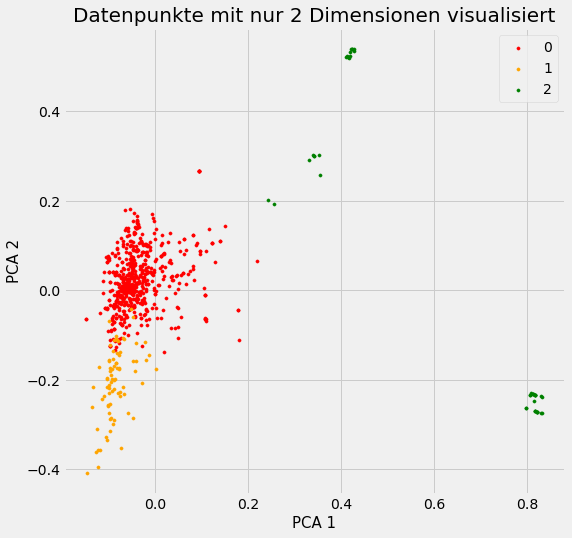

In [35]:
cmap = ["red","orange","green","yellowgreen","yellow","skyblue","blue","darkblue","magenta","purple","grey"]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PCA 1', fontsize = 15)
ax.set_ylabel('PCA 2', fontsize = 15)
ax.set_title('Datenpunkte mit nur 2 Dimensionen visualisiert', fontsize = 20)
targets = range(0,true_k)
colors = cmap[:true_k]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['k_means_pred'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PCA 1']
               , finalDf.loc[indicesToKeep, 'PCA 2']
               , c = color
               , s = 10)
ax.legend(targets)

# Fazit / Weiterführende Untersuchungen <a class="anchor" id="16"></a> 

Man kann anhand der Analyse nun verschiedene Erkenntnisse sammeln.

1. Die Daten betreffen vor allem Projekte aus dem Jahr 2020. 
2. Die Projekte halten insgesamt in der Regel ihren Budget Rahmen ein.
3. Die Organisationen mit denen vor allem zusammengearbeitet wird sind vor allem Hilfsorganisationen im Bereich der Flüchtlingshilfe und Humanitäre Hilfen
4. Fast 50% der Gelder werden von 5 Organisationen eingesammelt. Dabei ist auffällig, dass die Organisation mit den meisten Projekten (Organization for Security and Organization of Co-Operation in Europe). Hier nicht in den Top 5 Vertreten ist. 
5. Es lassen sich grob 3 Cluster aus den Texten für die Projekte erkennen. Diese sind aber relativ grob. Besonders ein Cluster für Student Exchanges/ Scholarships lässt sich gut abgrenzen allerdings umfasst dieser nur relativ wenig Einträge.

Man könnte um den Datensatz weiter zu untersuchen folgende Schritte noch durchführen:

* Evaluierung unterschiedlicher Cluster Algorithmen: z.B. K-Means vs. DBSCAN vs. HDBSCAN
* Weiteres Pre Processing um die Performance der Cluster Algorithmen zu verbessern: z.B. Reduzierung von bestimmten Wörtern im Datensatz, Title und Description nicht in einem Textfeld zusammenführen, eventuelle Rechtschreibfehler korrigieren lassen etc.

# <a class="anchor" id="quellenverzeichnis"></a> Quellenverzeichnis

* Datenquelle. Aufgerufen am 10.04.2021: https://www.auswaertiges-amt.de/blob/2107758/446327c4229e03967bb7818abe399eba/iati-weltweit-data.xml
* Python Built In XML Reader Dokumentation. Aufgerufen am 16.05.2021: https://docs.python.org/3/library/xml.etree.elementtree.html
* Pandas Dokumentation. Aufgerufen am 16.05.2021: https://pandas.pydata.org/
* Numpy Dokumentation. Aufgerufen am 16.05.2021: https://numpy.org/doc/stable/
* Spacy Dokumentation. Aufgeufen am 16.05.2021: https://spacy.io/
* SKLearn FunctionTransfomer. Aufgerufen am 16.05.2021: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html
* SKLearn Pipeline. Aufgerufen am 16.05.2021: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html?highlight=pipeline#sklearn.pipeline.Pipeline
* SKLearn TFIDFVectorizer. Aufgerufen am 16.05.2021: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidf#sklearn.feature_extraction.text.TfidfVectorizer
* SKLearn KMEANS. Aufgerufen am 16.05.2021: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans
* SKLearn silhouette Score. Aufgerufen am 16.05.2021: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html?highlight=silhouette#sklearn.metrics.silhouette_score